# RW Performance

In [68]:
import math
import matplotlib.pyplot as plt
import numpy as np
import sys

In [69]:
#conversion constants
m2ft = 3.28084 #1 meter to feet
ft2m = 1/m2ft
kt2ms = 0.51444444 #knots to meters per second
ms2kt = 1/kt2ms
RPM2rads = 1/60*2*math.pi
C2K = 273.15 #add to go from C to K
kgm32slug = 0.00237717/1.225 #

#constants definitions for ISA Atmosphere
TROPOSPHERE = 36089.24  #feet
T0 = 288.15 #Kelvin
p0 = 101325 #Pa
L_m = -6.5/1000 #K/m
L = L_m/m2ft #K/ft

STRATOSPHERE = 65617 #feet
Ts = 216.5 #Kelvin - temp at stratosphere
ps = 22632.06 #Pa


rho0 = 1.225 #kg/m3
R = 287.053 #m2/s2/K
ag_zero = -5.25588 *  R * L #in m/s2 -> gravity acceleration
gama = 1.4 #adiabatic coefficient for air


In [70]:
#slide 18, second eq should be p0
def getPressure(h):
    #h in feet
    #p in Pascals
    if h <= TROPOSPHERE:
        p = p0*(1+L/T0*h)**(-ag_zero/(R*L))
    else:
        p = ps*math.exp(-1*(h-TROPOSPHERE)/(R*Ts/ag_zero))
    return p

In [71]:
# temperature ratio
def theta(h):
    #h in feet
    if h <= TROPOSPHERE:
        theta_calc = 1+(L/T0)*h
    else:
        theta_calc = Ts/T0
    return theta_calc

In [72]:
# pressure ratio
def delta(h):
    #h in feet
    delta_calc = getPressure(h)/p0
    return delta_calc

In [73]:
def inv_delta(delta):
    #return the altitude for that delta
    idelta = (delta**(1/5.255863)-1)/(-0.00000687535)
    return idelta

In [74]:
#density ratio
def sigma(h):
    #h in feet
    sigma_calc = delta(h)/theta(h)
    return sigma_calc

In [75]:
def inv_sigma(sigma):
    isigma = ((sigma**0.235)-1)/(-0.00000687535)
    return isigma

In [76]:
def getAltitude(p):
    #p in Pascals
    #h in feet
    if p >= ps:
        h = T0/L*((p/p0)**(-(R*L/ag_zero))-1)
    else:
        h = TROPOSPHERE+R*Ts/ag_zero*math.log(p/ps)
    return h

In [77]:
def aSpdSound(T):
    #T comes in Kelvin
    if T >= 0:
        return math.sqrt(gama*R*T)
    else:
        return 0

In [78]:
def dAltitude(h, t):
    temp_constant = 0.00000687535
    DA = (((((1-temp_constant*h)**5.2561)/((t+C2K)/T0))**0.235)-1)/(-temp_constant)
    return DA

test case
<pre> alt  sigma  delta  theta  temp  press    dens     a    visc  k.visc  ratio
  -1 1.0296 1.0367 1.0069 522.2 2193.8 0.0024472 1120.3 0.376 1.54E-4  7.30
   0 1.0000 1.0000 1.0000 518.7 2116.2 0.0023769 1116.5 0.374 1.57E-4  7.10
   1 0.9711 0.9644 0.9931 515.1 2040.9 0.0023081 1112.6 0.372 1.61E-4  6.91
   2 0.9428 0.9298 0.9863 511.5 1967.7 0.0022409 1108.7 0.370 1.65E-4  6.72
   3 0.9151 0.8963 0.9794 508.0 1896.7 0.0021752 1104.9 0.368 1.69E-4  6.54
   4 0.8881 0.8637 0.9725 504.4 1827.7 0.0021109 1101.0 0.366 1.73E-4  6.36


</pre>

In [79]:
def getOAT_ISA(h):
    #given height, what is the ISA OAT?
    OAT = ((T0*(1-0.00000687535*h)))-C2K
    #outouts in C
    return OAT

In [80]:
h=1000
print(h, sigma(h), delta(h), theta(h))

1000 0.97106417085834 0.9643875362106196 0.9931244145875356


In [81]:
#pyformat.info for foramting info
for h in range(0,20000,2000):
    #print(h, theta(h)*T0, delta(h), sigma(h))
    print('altitude {}, Temp {:06.2f}, delta {:01.2f}, sigma {:01.2f}, check {:06.2f}'.format(h, theta(h)*T0, delta(h), sigma(h), getAltitude(getPressure(h))))

altitude 0, Temp 288.15, delta 1.00, sigma 1.00, check -00.00
altitude 2000, Temp 284.19, delta 0.93, sigma 0.94, check 2000.00
altitude 4000, Temp 280.23, delta 0.86, sigma 0.89, check 4000.00
altitude 6000, Temp 276.26, delta 0.80, sigma 0.84, check 6000.00
altitude 8000, Temp 272.30, delta 0.74, sigma 0.79, check 8000.00
altitude 10000, Temp 268.34, delta 0.69, sigma 0.74, check 10000.00
altitude 12000, Temp 264.38, delta 0.64, sigma 0.69, check 12000.00
altitude 14000, Temp 260.41, delta 0.59, sigma 0.65, check 14000.00
altitude 16000, Temp 256.45, delta 0.54, sigma 0.61, check 16000.00
altitude 18000, Temp 252.49, delta 0.50, sigma 0.57, check 18000.00


In [82]:
#checking the numbers...
h = np.arange(0, 50000, 1000)
vtheta = np.vectorize(theta)
vdelta = np.vectorize(delta)
vsigma = np.vectorize(sigma)
th = vtheta(h)
delt = vdelta(h)
sigm = vsigma(h)

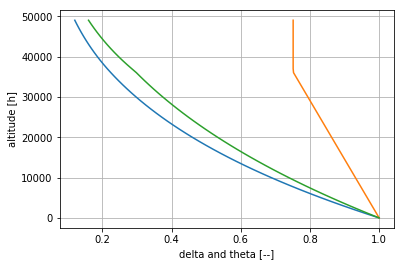

In [83]:
plt.plot(delt, h)
plt.plot(th, h)
plt.plot(sigm, h)
plt.xlabel('delta and theta [--]')
plt.ylabel('altitude [h]')
plt.grid(True)
plt.show()

In [84]:
def CAS(IAS, h):
    #altitude in feet
    #IAS in knots
    qc = 0.5*(rho0*sigma(h))*(IAS*kt2ms)**2
    CAS = (((2*gama)/(gama-1))*(p0/rho0)*((qc/p0+1)**((gama-1)/gama)-1))**(0.5)
    CAS = CAS*ms2kt
    return CAS

In [85]:
CAS(150,3000)

142.6617334227542

In [86]:
def TAS(IAS, h):
    #altitude in feet
    #IAS in knots
    qc = 0.5*(rho0*sigma(h))*(IAS*kt2ms)**2
    TAS = (((2*gama)/(gama-1))*(p0*delta(h)/(rho0*sigma(h)))*((qc/(p0*delta(h))+1)**((gama-1)/gama)-1))**(0.5)
    TAS = TAS*ms2kt
    return TAS

In [87]:
def EAS(IAS, h):
    #altitude in feet
    #IAS in knots
    calcTAS = TAS(IAS, h)
    EAS = calcTAS*sigma(h)**0.5
    return EAS

# checking results...

In [88]:
for h in range(0,50000,10000):
    print('height {}, IAS {:03.0f}, CAS {:03.0f}, TAS {:03.0f}, EAS {:03.0f}'.format(h, 150, CAS(150,h), TAS(150,h), EAS(150,h)))

height 0, IAS 150, CAS 149, TAS 149, EAS 149
height 10000, IAS 150, CAS 128, TAS 149, EAS 128
height 20000, IAS 150, CAS 109, TAS 149, EAS 109
height 30000, IAS 150, CAS 092, TAS 149, EAS 091
height 40000, IAS 150, CAS 074, TAS 149, EAS 074


In [89]:
p1=1013
mach=0.9
pp=p1*(1+((gama-1)/2)*mach**2)**(gama/(gama-1))
print(pp-p1)

700.2900533179929


In [90]:
def Ct(T,rho,A,omega,R):
    Ct = T/(rho*A*(omega*R)**2)
    return Ct

In [91]:
def Cp(P,rho,A,omega,R):
    Cp = P/(rho*A*(omega*R)**3)
    return Cp

LaTex entry:
$e^{i/pi} + 1 =0$

Let's define a few parameters for our helicopter

In [92]:
#helicopter design values that will be checked
weight_range = [4000, 4500, 5000] #lbs - test weights - from helicopter manual
altitude_range = [2000, 5000, 10000] #ft - test altitudes, also from manual
NR_std = 400 #RPM - governed RPM
ISA_range = np.array([-15, -5, 0, 5, 15, 30]) #C - delta ISA that we want

In [93]:
#test site limitations
weight_test_min = 4200 #lbs
weight_test_max = 5000 #lbs
altitude_test_min = 6000 #ft
altitude_test_max = 12000 #ft
OAT_test_min = 0 #C
OAT_test_max = 30 #C
d_altitude_test_min = dAltitude(altitude_test_min, OAT_test_min)
d_altitude_test_max = dAltitude(altitude_test_max, OAT_test_min)
print(d_altitude_test_max)

13021.993578633908


$\omega = \frac{NR_{test}}{NR_{std}}$

In [94]:
NR_test = 103  #enter percentage here.
NR_test = NR_test / (100) * NR_std #this transforms to RPM- it can be a different number
omega_small = NR_test/NR_std

Let's calculate some values of $\sigma\omega^2$ for the desired range

In [95]:
theta_range = np.array([])
sigma_req_max = 0
sigma_req_min = 1
for altitude in altitude_range:
    temp_OAT = getOAT_ISA(altitude)
    temp_OAT_range = ISA_range+temp_OAT
    theta_range = (temp_OAT_range+C2K)/T0
    temp_array=np.array([])
    temp_array=delta(altitude)/theta_range
    temp_max = temp_array.max()
    temp_min = temp_array.min()
    if sigma_req_max < temp_max: 
        sigma_req_max = temp_max
    if sigma_req_min > temp_min: 
        sigma_req_min = temp_min
W_over_sigma_omega_sq_req_min = min(weight_range)/(sigma_req_max*omega_small**2)
W_over_sigma_omega_sq_req_max = max(weight_range)/(sigma_req_min*omega_small**2)
print('min {:5.0f} lbs / max {:5.0f} lbs'
      .format(W_over_sigma_omega_sq_req_min, W_over_sigma_omega_sq_req_max))

min  3788 lbs / max  7096 lbs


Let's calculate some values of $\sigma\omega^2$ for the available range

In [96]:
W_over_sigma_omega_sq_avail_min = weight_test_min/(sigma_req_max*omega_small**2)
W_over_sigma_omega_sq_avail_max = weight_test_max/(sigma_req_min*omega_small**2)
print('min {:5.0f} lbs / max {:5.0f} lbs'
      .format(W_over_sigma_omega_sq_avail_min, W_over_sigma_omega_sq_avail_max))

min  3978 lbs / max  7096 lbs


In [97]:
#Now, let's pick a test range that fits
W_over_sigma_omega_sq_test_min = W_over_sigma_omega_sq_avail_min + (500-W_over_sigma_omega_sq_avail_min %500)
W_over_sigma_omega_sq_test_max = W_over_sigma_omega_sq_avail_max - (W_over_sigma_omega_sq_avail_max %500)
print(W_over_sigma_omega_sq_test_min , W_over_sigma_omega_sq_test_max)
W_step = 500
W_over_sigma_omega_sq_test_range = np.arange(W_over_sigma_omega_sq_test_min,
                                            W_over_sigma_omega_sq_test_max,
                                            W_step)
W_test = np.linspace(weight_test_min, weight_test_max, 5)

4000.0 7000.0


In [98]:
#and calculate sigma for each condition
outer_counter = 0
sigma_test = np.ndarray(shape = (len(W_over_sigma_omega_sq_test_range), len(W_test)))
daltitute_test = np.ndarray(shape = (len(W_over_sigma_omega_sq_test_range), len(W_test)))

for WOSS in W_over_sigma_omega_sq_test_range:
    #print(outer_counter, WOSS)
    inner_counter = 0
    for test_weight in W_test:
        sigma_test[outer_counter][inner_counter]=test_weight/(WOSS*(omega_small**2))
        daltitute_test[outer_counter][inner_counter]=inv_sigma(sigma_test[outer_counter][inner_counter])
        #print(test_weight, sigma_test[outer_counter][inner_counter], daltitute_test[outer_counter][inner_counter])
        inner_counter = inner_counter + 1
    outer_counter = outer_counter + 1    

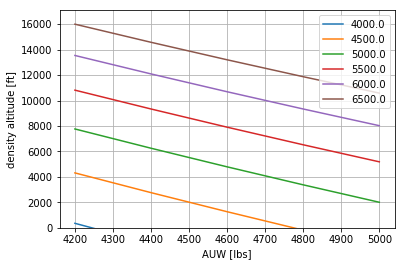

In [99]:
outer_counter = 0
for WOSS in W_over_sigma_omega_sq_test_range:
    plt.plot(W_test, daltitute_test[outer_counter][:], label = WOSS)
    #plt.plot(W_test, daltitute_test[outer_counter][:], label = 'Wref {:5.0f}'.format(WOSS))
    outer_counter = outer_counter + 1

plt.xlabel('AUW [lbs]')
plt.ylabel('density altitude [ft]')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(bottom=0)
#plt.Axes.set_ylim(bottom = 0)
plt.show()

With this graph, you can look up which density altitude to fly at the weight the helicopter is, for a given $\frac{W}{\sigma\omega^2}$

Now, let's plot the graphs for $\frac{W}{\delta}$

In [100]:
delta_req_max = 0
delta_req_min = 2
for altitude in altitude_range:
    if delta_req_max < delta(altitude): 
        delta_req_max = delta(altitude)
    if delta_req_min > delta(altitude): 
        delta_req_min = delta(altitude)

W_over_delta_req_min = min(weight_range)/(delta_req_max)
W_over_delta_req_max = max(weight_range)/(delta_req_min)
print('min {:5.0f} lbs / max {:5.0f} lbs'
      .format(W_over_delta_req_min, W_over_delta_req_max))

min  4302 lbs / max  7271 lbs


Let's calculate some values of $\frac{W}{\delta}$ for the available range

In [101]:
W_over_delta_avail_min = weight_test_min/(delta_req_max)
W_over_delta_avail_max = weight_test_max/(delta_req_min)
print('available: min {:5.0f} lbs / max {:5.0f} lbs'
      .format(W_over_delta_avail_min, W_over_delta_avail_max))

available: min  4517 lbs / max  7271 lbs


In [102]:
#Now, let's pick a test range that fits
W_over_delta_test_min = W_over_delta_avail_min + (500-W_over_delta_avail_min %500)
W_over_delta_test_max = W_over_delta_avail_max - (W_over_delta_avail_max %500)
print('test range ',W_over_delta_test_min , W_over_delta_test_max)
W_step = 500
W_over_delta_test_range = np.arange(W_over_delta_test_min,
                                            W_over_delta_test_max,
                                            W_step)
#dont need to define weights, they were already defined.
#If you want to cjange, just redefine below
#W_test = np.linspace(weight_test_min, weight_test_max, 5)

test range  5000.0 7000.0


In [103]:
#and calculate omega_small sqrt theta for each condition
outer_counter = 0
delta_test = np.ndarray(shape = (len(W_over_delta_test_range), len(W_test)))
daltitute_test = np.ndarray(shape = (len(W_over_delta_test_range), len(W_test)))

for WOD in W_over_delta_test_range:
    #print(outer_counter, WOSS)
    inner_counter = 0
    for test_weight in W_test:
        delta_test[outer_counter][inner_counter]=test_weight/(WOD)
        daltitute_test[outer_counter][inner_counter]=inv_delta(delta_test[outer_counter][inner_counter])
        #print(test_weight, sigma_test[outer_counter][inner_counter], daltitute_test[outer_counter][inner_counter])
        inner_counter = inner_counter + 1
    outer_counter = outer_counter + 1    

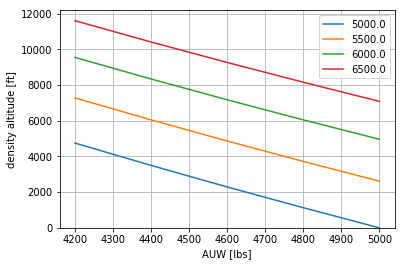

In [104]:
outer_counter = 0
for WOD in W_over_delta_test_range:
    plt.plot(W_test, daltitute_test[outer_counter][:], label = WOD)
    #plt.plot(W_test, daltitute_test[outer_counter][:], label = 'Wref {:5.0f}'.format(WOSS))
    outer_counter = outer_counter + 1

plt.xlabel('AUW [lbs]')
plt.ylabel('density altitude [ft]')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(bottom=0)
#plt.Axes.set_ylim(bottom = 0)
plt.show()

This is the $\frac{W}{\delta}$ graph that you use to find a suitable altitude given the current aircraft weight (for a chosen $\frac{W}{\delta}$ )

Now, let's look at the data reduction

In [105]:
weights_flown = np.array([4400, 4500, 4800, 4900]) #in this case, lbs
altitudes_flown = np.array([6000, 5750, 4000, 3500])
OATs_flown = np.array([20, 25, 27, 31])
NR_flown = np.array([103, 103, 103, 103])
torque_flown = np.array([78, 82, 85, 87])
if len(weights_flown) != len(altitudes_flown):
    print('check weights and altitudes arrays')
    sys.exit('array size mismatch')
if len(OATs_flown) != len(NR_flown):
    print('check OAT and NR_flown arrays')
    sys.exit('array size mismatch')
if len(torque_flown) != len(NR_flown):
    print('check torque and NR_flown arrays')
    sys.exit('array size mismatch')

In [106]:
#calculate actual W/sigma omega sq
theta_flown = (OATs_flown+C2K)/T0
delta_flown = vdelta(altitudes_flown) #using the vectorized delta function
sigma_flown = delta_flown/theta_flown

In [107]:
print(sigma_flown)
print(delta_flown[0], theta_flown[0], delta_flown[0]/theta_flown[0])

[ 0.78770938  0.78182548  0.82913266  0.83354556]
0.801377775617 1.01735207357 0.787709384424


In [108]:
#TODO - put all aircraft data on a dedicated cell
ESHP_nominal = 800 #SHP for all engines - net, if there are losses, need to subtract
Kq = 1
#TODO - with variable NR, Kq needs to be variable too
ESHP_flown = torque_flown*Kq*NR_flown
ESHP_ref_flown = ESHP_flown/sigma_flown
NR_flown_RPM = NR_flown / (100) * NR_std #this transforms to RPM- it can be a different number
omega_small = NR_flown_RPM/NR_std

In [109]:
print(omega_small)

[ 1.03  1.03  1.03  1.03]


In [110]:
W_over_sigma_omega_sq_flown = weights_flown/(sigma_flown*omega_small**2)

In [111]:
rotor_radius = 5 #m
disk_area = math.pi*rotor_radius**2
rho_flown = rho0*kgm32slug*sigma_flown #this is in English Units
Cp_flown = Cp(ESHP_flown, rho_flown, disk_area, NR_flown_RPM, rotor_radius)

In [112]:
print(Cp_flown)

[  6.24905036e-06   6.61895573e-06   6.46964340e-06   6.58681325e-06]


In [113]:
Ct_flown = Ct(weights_flown, rho_flown, disk_area, NR_flown_RPM, rotor_radius)

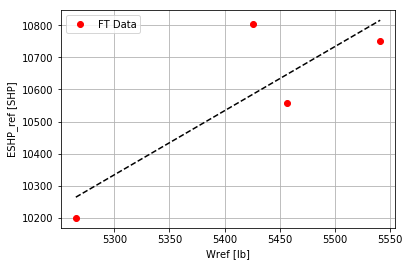

In [114]:
plt.plot(W_over_sigma_omega_sq_flown, ESHP_ref_flown, 'ro', label = 'FT Data')
plt.xlabel('Wref [lb]')
plt.ylabel('ESHP_ref [SHP]')
plt.legend()
plt.grid(True)
#plt.gca().set_ylim(bottom=0)
#plt.Axes.set_ylim(bottom = 0)
fit_line = np.polyfit(W_over_sigma_omega_sq_flown, ESHP_ref_flown, 1)
fit_fn = np.poly1d(fit_line)
plt.plot(W_over_sigma_omega_sq_flown, fit_fn(W_over_sigma_omega_sq_flown), '--k', label = 'Line Fit')
plt.show()

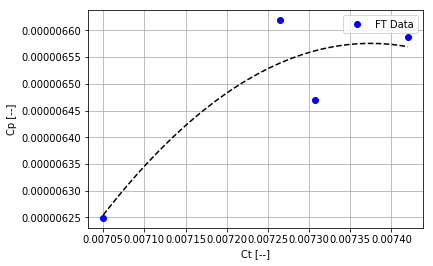

In [115]:
plt.plot(Ct_flown, Cp_flown, 'bo', label = 'FT Data')
plt.xlabel('Ct [--]')
plt.ylabel('Cp [--]')
plt.legend()
plt.grid(True)
#plt.gca().set_ylim(bottom=0)
#plt.Axes.set_ylim(bottom = 0)
fit_line = np.polyfit(Ct_flown, Cp_flown, 2)
fit_fn = np.poly1d(fit_line)
temp_array = np.linspace(Ct_flown.min(), Ct_flown.max(), 100)
plt.plot(temp_array, fit_fn(temp_array), '--k', label = 'Line Fit')
plt.show()